In [1]:
!pip install pandas
!pip install rdflib
!pip install SPARQLWrapper

In [2]:
# import pandas library using alias pd
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import numpy as np
import time
from tqdm import tqdm
import pickle

In [3]:
import time
import datetime
import logging


# Set Logger so that we can track the progress even when the kernel is not reponding    
logger = logging.getLogger()
    
def setup_file_logger(log_file):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)
    
def log(message):
    #outputs to Jupyter console
    print('{} {}'.format(datetime.datetime.now(), message))
    #outputs to file
    logger.info(message)
    
setup_file_logger('out.log')

## 1) Data Preparation

### 1.1 Get List of subclasses and the number of instance for each of them

In [4]:
# Initialize SPARQL endpoint
dbpedia_sparql = SPARQLWrapper("https://dbpedia.org/sparql")

# Define the SPARQL query
dbpedia_sparql.setQuery("""
   SELECT ?subclass (COUNT(DISTINCT ?instance) AS ?count)
   WHERE {
     ?instance a ?subclass.
     ?subclass rdfs:subClassOf dbo:Person.
     FILTER (?subclass != dbo:Person)
   }
   GROUP BY ?subclass
   ORDER BY ASC(?count)
""")

# Set return format to JSON
dbpedia_sparql.setReturnFormat(JSON)

# Execute the query and process the results
results = dbpedia_sparql.query().convert()

subclasses = {}
for result in results["results"]["bindings"]:
    subclass_uri = result["subclass"]["value"]
    count = result["count"]["value"]
    subclass = subclass_uri.replace("http://dbpedia.org/ontology/", "")
    subclasses[subclass] = int(count)  # Convert count to integer

In [5]:
subclasses

{'Judge': 124,
 'Monarch': 245,
 'Spy': 261,
 'AmericanLeader': 264,
 'Pilot': 286,
 'HorseTrainer': 355,
 'PoliceOfficer': 413,
 'Presenter': 670,
 'BusinessPerson': 691,
 'Astronaut': 738,
 'Engineer': 885,
 'Chef': 897,
 'Youtuber': 900,
 'PlayboyPlaymate': 979,
 'Economist': 1720,
 'Journalist': 1858,
 'Model': 2045,
 'BeautyQueen': 2987,
 'Philosopher': 2987,
 'Religious': 4832,
 'Architect': 5574,
 'Criminal': 6081,
 'Noble': 7949,
 'Academic': 10663,
 'Coach': 10954,
 'Royalty': 22720,
 'Cleric': 25434,
 'SportsManager': 29156,
 'MilitaryPerson': 50255,
 'Writer': 51821,
 'Scientist': 52119,
 'OfficeHolder': 66597,
 'Artist': 107644,
 'Politician': 200848,
 'OrganisationMember': 456914,
 'Athlete': 578933}

In [6]:
subclasses.pop("Judge")

124

### 1.2 Combine Collected Data into a Dataframe

In [7]:
import math

df = pd.read_csv('Judge.csv')

# load the data
for subclass, count in subclasses.items():
    try:
        if count < 10000:
            temporary_df = pd.read_csv(f'{subclass}.csv')
            df = pd.concat([df, temporary_df], ignore_index=True)
        else:
            for i in range(0, math.ceil(count / 10000) + 2):
                temporary_df = pd.read_csv(f'{subclass}/{subclass}iteration{i}.csv')
                df = pd.concat([df, temporary_df], ignore_index=True)
    except FileNotFoundError:
        print (f'{subclass}/{subclass}iteration{i}.csv NOT FOUND')
    
df.shape

Academic/Academiciteration1.csv NOT FOUND
Coach/Coachiteration2.csv NOT FOUND
Royalty/Royaltyiteration3.csv NOT FOUND
Cleric/Clericiteration3.csv NOT FOUND
SportsManager/SportsManageriteration3.csv NOT FOUND
MilitaryPerson/MilitaryPersoniteration6.csv NOT FOUND
Writer/Writeriteration6.csv NOT FOUND
Scientist/Scientistiteration7.csv NOT FOUND
OfficeHolder/OfficeHolderiteration7.csv NOT FOUND
Artist/Artistiteration12.csv NOT FOUND
Politician/Politicianiteration20.csv NOT FOUND
OrganisationMember/OrganisationMemberiteration0.csv NOT FOUND
Athlete/Athleteiteration1.csv NOT FOUND


(979648, 7)

In [8]:
# Check if all the subclasses are present in the dataframe to be preprocessed
df['subclass'].value_counts()

Athlete            250573
Politician         191191
Artist             120000
OfficeHolder        70000
Scientist           70000
Writer              60000
MilitaryPerson      56218
Cleric              30000
SportsManager       29192
Royalty             27736
Coach               10958
Academic            10000
Noble               10000
Philosopher          8875
Criminal             7076
Architect            5590
Religious            4868
BeautyQueen          2992
Economist            2738
Model                2048
Journalist           1865
PlayboyPlaymate       979
Youtuber              901
Chef                  899
Engineer              891
Astronaut             742
BusinessPerson        691
Presenter             671
PoliceOfficer         413
HorseTrainer          358
Pilot                 286
AmericanLeader        265
Spy                   261
Monarch               247
Judge                 124
Name: subclass, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979648 entries, 0 to 979647
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   subclass          979648 non-null  object 
 1   instance          979648 non-null  object 
 2   wikiDataID        948740 non-null  object 
 3   gender            926522 non-null  object 
 4   age               979648 non-null  int64  
 5   birthYear         250573 non-null  float64
 6   publication_year  957813 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 52.3+ MB


From above, it can be seen that the wikiDataID, , gender, birthYear and publication_year column has some null values.

### 1.3 Removing Duplicated Rows

#### 1.3.1 Removing Duplicated Instance and WikidataID 

In [10]:
duplicated_rows = df[df.duplicated(subset=['instance', 'wikiDataID'], keep=False)].sort_values(by=['instance'])
duplicated_rows

,subclass,instance,wikiDataID,gender,age,birthYear,publication_year
537892,Politician,100th_Delaware_General_Assembly,Q4546229,NaN,0,NaN,2009.0
347886,OfficeHolder,100th_Delaware_General_Assembly,Q4546229,NaN,0,NaN,2009.0
537893,Politician,101st_Delaware_General_Assembly,Q4546348,NaN,0,NaN,2009.0
347888,OfficeHolder,101st_Delaware_General_Assembly,Q4546348,NaN,0,NaN,2009.0
537894,Politician,102nd_Delaware_General_Assembly,Q4546419,NaN,0,NaN,2009.0
...,...,...,...,...,...,...,...
728981,Politician,Ōyama_Iwao,Q359819,male,74,NaN,2003.0
217876,MilitaryPerson,Živko_Budimir,Q2478723,male,62,NaN,2011.0
729044,Politician,Živko_Budimir,Q2478723,male,62,NaN,2011.0
729047,Politician,Živojin_Mišić,Q1138038,male,66,NaN,2003.0


We can see above that there are 134,353 rows that have duplicated instance and wikiDataID, sicne we only need one rows of these duplicated rows, we wil keep only the first rows of such.

In [11]:
df1 = df.drop_duplicates(subset=['instance', 'wikiDataID'], keep='first')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911850 entries, 0 to 979647
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   subclass          911850 non-null  object 
 1   instance          911850 non-null  object 
 2   wikiDataID        880999 non-null  object 
 3   gender            859866 non-null  object 
 4   age               911850 non-null  int64  
 5   birthYear         245539 non-null  float64
 6   publication_year  890068 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 55.7+ MB


#### 1.3.2 Removing Duplicated Instance and WikidataID = Removing All Duplicated Rows

In [12]:
df1.duplicated().sum() 

0

After dropping all the duplicates, we can infer that there are 979648 - 911850 = 67,798 rows that have duplicated instance and wikiDataID and have been removed.

#### 1.3.3 Duplicated WikidataID (which should be unique for each instance)

In [13]:
df1['wikiDataID'].duplicated().sum()

148921

However, the WikiDataID columns still shows some duplication which should not happpened since we have deleted all the duplicates and since wikiDataID is unique. Thus, I think this happened for some error when collecting the data through the API's where two or more same instance might have been represented by mutiple wikiDataID but only one of them is correct

In [14]:
duplicated_wikidata = df1[df1.duplicated(subset=['subclass', 'instance'], keep=False)].sort_values(by=['instance'])
duplicated_wikidata

,subclass,instance,wikiDataID,gender,age,birthYear,publication_year
41338,Criminal,"2016_St._Cloud,_Minnesota_knife_attack",Q42915632,NaN,-8,NaN,2016.0
41337,Criminal,"2016_St._Cloud,_Minnesota_knife_attack",Q26933993,NaN,-8,NaN,2016.0
349407,OfficeHolder,A._K._Fazlul_Huq,Q3242246,male,89,NaN,2005.0
349408,OfficeHolder,A._K._Fazlul_Huq,Q9258264,NaN,89,NaN,2005.0
217955,Writer,A._L._Kennedy,Q278872,female,59,NaN,2004.0
...,...,...,...,...,...,...,...
728657,Politician,Éric_Dupond-Moretti,Q93228978,male,63,NaN,2017.0
728831,Politician,Ömer_Çelik,Q91468051,male,56,NaN,2013.0
728830,Politician,Ömer_Çelik,Q297516,male,56,NaN,2013.0
102404,Royalty,Şehzade_Kasım,Q21523791,male,0,NaN,2022.0


After some initial observation, it is found that my intuation is correct, for example the instance Ömer_Çelik have two wikiDataID but only one is correct which is Q297516. Meanwhile, the wikiDataID = Q91468051 associated with him deos not exists. I plan to run a sparql query in wikidata to get the actual wikidataId for each of these instances and replace them in the df

In [15]:
instances_with_multiple_ids = duplicated_wikidata.groupby(['subclass', 'instance'])['wikiDataID'].unique()
instances_with_multiple_ids

subclass  instance         
Academic  Alan_Martin_Boase                               [Q18917167, Q19258718]
          Albert_Elsen                                    [Q59628885, Q19753752]
          Andre_Franke                                   [Q67470670, Q114345084]
          Andrew_Lambert                                   [Q4757681, Q60103671]
          Autumn_Stanley       [Q95682724, Q95680876, Q95637638, Q95336311, Q...
                                                     ...                        
Writer    Max_Müller                                         [Q60074, Q55068911]
          Mbongeni_Ngema                                   [Q10327912, Q6799750]
          Mel_Odom_(author)                                 [Q4331780, Q6810802]
          Melinda_Metz         [Q22107416, Q238361, Q23780935, Q2375655, Q237...
Youtuber  TimTheTatman                                   [Q61789029, Q111584802]
Name: wikiDataID, Length: 2625, dtype: object

In [16]:
df2 = df1[~df1.duplicated(subset=['subclass', 'instance'], keep='first')].sort_values(by=['instance'])
df2

,subclass,instance,wikiDataID,gender,age,birthYear,publication_year
417884,Artist,!PAUS3,Q3466056,male,43,NaN,2011.0
417885,Artist,$pacely,Q73507574,male,32,NaN,2018.0
38134,Criminal,%22Baby_Lollipops%22_murder,Q64875934,NaN,63,NaN,2023.0
417886,Artist,%22Bassy%22_Bob_Brockmann,Q13416958,male,62,NaN,2013.0
537884,Politician,%22Big%22_Donnie_MacLeod,Q18645783,male,75,NaN,2014.0
...,...,...,...,...,...,...,...
102470,Royalty,Ḫarapšili,Q742087,female,0,NaN,2012.0
102471,Royalty,Ḫattušili_III,Q297588,male,0,NaN,2004.0
26705,Religious,Ṭhānissaro_Bhikkhu,Q7710407,male,75,NaN,2006.0
102472,Royalty,Ỷ_Lan,Q10843033,female,0,NaN,2010.0


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791004 entries, 417884 to 102473
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   subclass          791004 non-null  object 
 1   instance          791004 non-null  object 
 2   wikiDataID        760153 non-null  object 
 3   gender            743194 non-null  object 
 4   age               791004 non-null  int64  
 5   birthYear         242387 non-null  float64
 6   publication_year  769224 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 48.3+ MB


Actual df = 911850, duplicated wikiDataID = 123471, unique wikidataid from the duplicated = 2625; Cleaned df = 911850 - 123471 + 2625 = **791004** which is consistent with the information above.

In [18]:
i=0
for (subclass, instance), ids in instances_with_multiple_ids.items():
    if len(ids) > 5:
        i+=1
print(i)

144


After a few tries, I found that some of the instances with multiple WikidataID have more than 5 wikidataID attached to it with some reaching to more than 50 wikidataID. Additionally, out of the more than 50 WikidataID, none of them are correct. Moreover, those with less than 5 wikidataID have more tendency to contain the actual wikidataID. Therefore, I decided to only iterate through those instances with less than or equal to 5. I think it is also reasonabel to remove those instance with wikidataid more than 5 since there's only 144 of them out of 2625 instances which is only about  5.5% of the whole instances with multiple WikidataID.

In [19]:
def get_instance_from_dbpedia(wikidata_id):
    # Initialize the SPARQL wrapper
    dbpedia_sparql = SPARQLWrapper('https://dbpedia.org/sparql')

    # Define the query to get the DBpedia resource URI
    query = f"""
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX wd: <http://www.wikidata.org/entity/>

    SELECT ?instance WHERE {{
      ?instance owl:sameAs wd:{wikidata_id}.
    }}
    """
    
    dbpedia_sparql.setQuery(query)
    dbpedia_sparql.setReturnFormat(JSON)
    
    while True:
        try:
            # Execute the query and fetch results
            results = dbpedia_sparql.query().convert()
                
            if results["results"]["bindings"]:
                instance = results["results"]["bindings"][0]["instance"]["value"]
                return instance.replace("http://dbpedia.org/resource/", "")
            else:
                return None
        
        except Exception as e:
            print(f"Error: {e}. Retrying after 2 seconds...")
            time.sleep(2)
            get_instance_from_dbpedia(wikidata_id)

def get_correct_wikidata_ids(instances_with_multiple_ids):
    mapping = {}
    total_instances = len(instances_with_multiple_ids)
    
    with tqdm(total=total_instances, desc='Processing Instances') as pbar:
        for (subclass, instance), ids in instances_with_multiple_ids.items():
            if len(ids) <= 5:
                for wikidata_id in ids:
                    name = get_instance_from_dbpedia(wikidata_id)
                    if instance == name:
                        mapping[(subclass, instance)] = wikidata_id
                        break
            else: 
                mapping[(subclass, instance)] = None
            pbar.update(1)
                
    return mapping

# Example usage:
# Assuming `instances_with_multiple_ids` is defined somewhere
# wikidata_mapping = get_correct_wikidata_ids(instances_with_multiple_ids)

In [20]:
# wikidata_mapping = get_correct_wikidata_ids(instances_with_multiple_ids)

The above code gets the correct, single Wikidata ID or None for each instances with multiple WikidataID in the orginal dataframe

In [21]:
# wikidata_mapping

In [22]:
# # Specify the path where you want to save the pickle file
# file_path = "wikidata_mapping.pkl"

# # Open the file in write-binary mode and save the dictionary
# with open(file_path, 'wb') as file:
#     pickle.dump(wikidata_mapping, file)

# print("Dictionary saved to file using pickle.")

In [23]:
# # Specify the path of the file you want to read
file_path = "wikidata_mapping.pkl"

# Open the file in read-binary mode and load the dictionary
with open(file_path, 'rb') as file:
    wikidata_mapping = pickle.load(file)

print("Dictionary loaded from file using pickle.")

Dictionary loaded from file using pickle.


In [24]:
df2['wikiDataID'].duplicated().sum()

31641

In [25]:
# Define function to get the correct wikiDataID from the mapping
def get_correct_wikidata_id(row, mapping):
    key = (row['subclass'], row['instance'])
    return mapping.get(key, row['wikiDataID'])  # Fallback to the original wikiDataID if no mapping is found

# Update df2 with the correct wikiDataID
df2['correct_wikiDataID'] = df2.apply(lambda row: get_correct_wikidata_id(row, wikidata_mapping), axis=1)

# Drop the old wikiDataID column and rename new column
df2 = df2.drop(columns='wikiDataID')
df2 = df2.rename(columns={'correct_wikiDataID': 'wikiDataID'})

print("Updated df2 with Correct WikiDataID:")
df2

Updated df2 with Correct WikiDataID:


,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
417884,Artist,!PAUS3,male,43,NaN,2011.0,Q3466056
417885,Artist,$pacely,male,32,NaN,2018.0,Q73507574
38134,Criminal,%22Baby_Lollipops%22_murder,NaN,63,NaN,2023.0,Q64875934
417886,Artist,%22Bassy%22_Bob_Brockmann,male,62,NaN,2013.0,Q13416958
537884,Politician,%22Big%22_Donnie_MacLeod,male,75,NaN,2014.0,Q18645783
...,...,...,...,...,...,...,...
102470,Royalty,Ḫarapšili,female,0,NaN,2012.0,Q742087
102471,Royalty,Ḫattušili_III,male,0,NaN,2004.0,Q297588
26705,Religious,Ṭhānissaro_Bhikkhu,male,75,NaN,2006.0,Q7710407
102472,Royalty,Ỷ_Lan,female,0,NaN,2010.0,Q10843033


In [26]:
df2['wikiDataID'].duplicated().sum()

31578

The duplicated WkiDataID has reduced from 148921 to 31758 which is about 79% reduction in duplicated WikiDataID

### 1.4 Handling Missing Data 

#### 1.4.1 Identify the Number of Missing Values 

In [27]:
df2.isna().sum()

subclass                 0
instance                 0
gender               47810
age                      0
birthYear           548617
publication_year     21780
wikiDataID           30995
dtype: int64

We can observe that the subclass, instance, and age column has no missing data. All other columns have missing data that we need to handle to ensure the data quality. Just to be sure, we will roughly look at the subclass, instance and age column to make sure they have no hidden missing values.

#### a) Subclass column

In [28]:
df2['subclass'].describe()

count      791004
unique         35
top       Athlete
freq       242387
Name: subclass, dtype: object

In [29]:
df2['subclass'].value_counts()

Athlete            242387
Politician         128305
Artist              93129
OfficeHolder        59516
Scientist           50400
MilitaryPerson      49965
Writer              33520
SportsManager       29155
Cleric              24009
Royalty             22024
Coach               10954
Noble                7037
Criminal             6079
Architect            5560
Academic             4920
Religious            4816
Philosopher          2987
BeautyQueen          2910
Model                2045
Journalist           1858
Economist            1720
PlayboyPlaymate       979
Youtuber              900
Chef                  897
Engineer              885
Astronaut             738
BusinessPerson        691
Presenter             670
PoliceOfficer         413
HorseTrainer          355
Pilot                 286
AmericanLeader        264
Spy                   261
Monarch               245
Judge                 124
Name: subclass, dtype: int64

#### b) Instance column

In [30]:
len(df2['instance'].unique())

791004

#### c) Age column

In [31]:
df2['age'].describe()

count    791004.000000
mean         36.583676
std          80.368008
min       -3395.000000
25%           0.000000
50%          44.000000
75%          70.000000
max        4431.000000
Name: age, dtype: float64

We can see that the minimum value for age is -3395 which is not possible in the real world. Thus, we will be taking the age column into account whie handling the missing values

#### d) Missing columns to be solved

From above, we can conclude that only the instance and subclass column does not have any missing values. Thus, we will try to handle the missing values for all the other columns to prevent data quality issues.

#### 1.4.2 Missing Data: Gender Column

In [32]:
# summarization of Culmen length (mm) before imputation
df2["gender"].describe()

count     743194
unique        52
top         male
freq      615154
Name: gender, dtype: object

In [33]:
gender_distribution_count = df2["gender"].value_counts()
gender_distribution_count

male                                                                          615154
female                                                                        127442
trans woman                                                                      225
non-binary                                                                       158
trans man                                                                         54
male organism                                                                     30
genderfluid                                                                       17
eunuch                                                                            16
intersex woman                                                                    15
intersex man                                                                      10
genderqueer                                                                        7
transgender                                                      

There are 52 unique values for the gender column, with male being the majority gender for the instances. There are also 53,078 instances that are not assigned to a gender which we need to handle later. There are also some unwanted values that can be seem to be starting with a common link which is "http://www.wikidata.org/.well-known/genid". We will start by replacing those values (associated to 28 rows) with null before deciding what to do with the null values 

In [34]:
# Replace NaN values with an empty string temporarily
s1 = df2['gender'].fillna('')

# Create a boolean mask for unwanted gender values
unwanted_gender_mask = s1.str.contains('http://www.wikidata.org/.well-known/genid', regex=False)

# Count the unwanted gender values
unwanted_gender_count = unwanted_gender_mask.sum()

# Replace unwanted gender values with NaN
df2.loc[unwanted_gender_mask, 'gender'] = np.nan

# Output the count of unwanted gender values
unwanted_gender_count

28

In [35]:
gender_distribution_count = df2["gender"].value_counts()
gender_distribution_count

male                  615154
female                127442
trans woman              225
non-binary               158
trans man                 54
male organism             30
genderfluid               17
eunuch                    16
intersex woman            15
intersex man              10
transgender                7
genderqueer                7
intersex                   6
two-spirit                 5
female organism            4
agender                    4
transmasculine             4
cisgender woman            2
androgynos                 1
bigender                   1
travesti                   1
cisgender man              1
faʻafafine                 1
undisclosed gender         1
Name: gender, dtype: int64

In [36]:
# summarization of Culmen length (mm) before imputation
df2["gender"].describe()

count     743166
unique        24
top         male
freq      615154
Name: gender, dtype: object

In [37]:
df2['gender'].isna().sum()

47838

#### 1.4.3 Missing Data: Age Column

In [38]:
df2['age'].describe()

count    791004.000000
mean         36.583676
std          80.368008
min       -3395.000000
25%           0.000000
50%          44.000000
75%          70.000000
max        4431.000000
Name: age, dtype: float64

As we have observed that -3395 which is not possible in the real world. Thus, we will inspect further and get all rows with age less than and equal to 0.

In [39]:
df2.loc[df2['age'] <= 0] 

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
537885,Politician,%22Bulldog%22_Ben_Robinson,male,0,NaN,2022.0,Q112440117
417888,Artist,%22Frantic%22_Fay_Thomas,female,-46,NaN,2020.0,Q101445578
161666,MilitaryPerson,%60Adnan_%60Uqla,NaN,0,NaN,2019.0,NaN
347884,OfficeHolder,''Congregatio_Immaculati_Cordis_Mariae'',NaN,0,NaN,NaN,NaN
74738,Royalty,'Abd_Allah_II_ibn_'Ali_'Abd_ash-Shakur,male,0,NaN,2005.0,Q2820897
...,...,...,...,...,...,...,...
27093,Religious,Ḥayyim_Yitzḥak_Mussafia,male,0,NaN,2020.0,Q104528636
102470,Royalty,Ḫarapšili,female,0,NaN,2012.0,Q742087
102471,Royalty,Ḫattušili_III,male,0,NaN,2004.0,Q297588
102472,Royalty,Ỷ_Lan,female,0,NaN,2010.0,Q10843033


There are 276,088 rows with age <= 0. We could try using the wikidata api to retrieve the value for age since we have only used dbpedia to retrieve the age before. To do that, we still need the wikiDataID of the instances. Thus, we will make sure that majority of the instances with age<=0 does have wikiDataID as some of them might have null values.

##### 1.4.3.1 Case 1: Age <=0 

In [40]:
df2.loc[((df2['age'] <= 0) & (df2['wikiDataID'].isna()))]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
161666,MilitaryPerson,%60Adnan_%60Uqla,NaN,0,NaN,2019.0,NaN
347884,OfficeHolder,''Congregatio_Immaculati_Cordis_Mariae'',NaN,0,NaN,NaN,NaN
26240,Philosopher,'Abd_al-Haqq_al-Dehlawi__1,NaN,0,NaN,NaN,NaN
161667,MilitaryPerson,'Ali_ibn_Aban_al-Muhallabi,NaN,0,NaN,NaN,NaN
161668,MilitaryPerson,'Ali_ibn_Muhammad_(Zanj_leader),NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
102435,Royalty,Şehzade_Sultan,NaN,0,NaN,NaN,NaN
102441,Royalty,Şemsiruhsar_Hatun,NaN,0,NaN,2014.0,NaN
217870,MilitaryPerson,Žanis_Bļumbergs,NaN,0,NaN,2020.0,NaN
217874,MilitaryPerson,Željko_Ražnatović,NaN,0,NaN,2020.0,NaN


In [41]:
wrong_age_subset = df2.loc[((df2['age'] <= 0) & (df2['wikiDataID'].notna())), ['instance', 'wikiDataID', 'age']].values.tolist()
len(wrong_age_subset)

213170

Out of all 237,923 instances that has age <=0, there are 213,170 instances that have the wikidataID and 24,753 instances without wikidataID. We will try to get the age of those instances with wikidataID as they have more counts. After that, we will decide what to do with those without wikidataID

In [42]:
import time
from tqdm import tqdm

def get_age_from_wikidata(wikidata_id):
    """
    Fetches the age of an individual from Wikidata using their Wikidata ID.
    
    Args:
        wikidata_id (str): The Wikidata ID of the individual.
    
    Returns:
        int or None: The calculated age if found, otherwise None.
    """
    from SPARQLWrapper import SPARQLWrapper, JSON
    
    # Initialize the SPARQL wrapper
    wikidata_sparql = SPARQLWrapper('https://query.wikidata.org/sparql')

    # Define the SPARQL query to get birth and death dates
    query = f"""
    SELECT ?birthDate ?deathDate (YEAR(COALESCE(?deathDate, NOW())) - YEAR(?birthDate) AS ?age)
    WHERE {{
        wd:{wikidata_id} wdt:P569 ?birthDate.  # Date of birth
        OPTIONAL {{ wd:{wikidata_id} wdt:P570 ?deathDate. }}  # Date of death (optional)
    }}
    """
    
    wikidata_sparql.setQuery(query)
    wikidata_sparql.setReturnFormat(JSON)
    
    max_retries = 3
    retries = 0

    while retries < max_retries:
        try:
            # Execute the query and fetch results
            results = wikidata_sparql.query().convert()
            
            if results["results"]["bindings"]:
                # Fetch age from results
                age = results["results"]["bindings"][0]["age"]["value"]
                return int(age)
            else:
                return None
        
        except Exception as e:
            print(f"Error: {e}. Retrying after 2 seconds...")
            retries += 1
            time.sleep(3)
    
    print("Max retries reached. Could not fetch data.")
    return None

def subset_get_age(wrong_age_subset, log_file="age0_processed_instances.txt"):
    mapping = {}
    total_instances = len(wrong_age_subset)
    
    # Read the log file to find already processed instances
    processed = set()
    try:
        with open(log_file, 'r') as f:
            for line in f:
                instance, wikidata_id, age = line.strip().split('\t')
                processed.add((instance, wikidata_id))
                mapping[(instance, wikidata_id)] = int(age)
    except FileNotFoundError:
        pass
    
    with tqdm(total=total_instances, desc='Processing Instances') as pbar, open(log_file, 'a') as f:
        for instance, wikidata_id, _ in wrong_age_subset:
            if (instance, wikidata_id) in processed:
                pbar.update(1)
                continue
            
            age = get_age_from_wikidata(wikidata_id)
            mapping[(instance, wikidata_id)] = age
            
            # Log the instance to the file
            f.write(f"{instance}\t{wikidata_id}\t{age}\n")
            f.flush()  # Ensure the data is written to the file immediately
            
            pbar.update(1)
    
    return mapping

# Example usage:
# wrong_age_subset = [("Instance1", "Q42", 42), ("Instance2", "Q123", 36), ...]
# subset_get_age(wrong_age_subset)

In [43]:
def age_txt_to_dict(filename): 
    age_mapping = {} 
    with open(filename, 'r') as f:
        for line in f:
            instance, wikidata_id, age = line.strip().split('\t')
            if age and age != 'None':  # Ensure age is neither empty nor 'None'
                age_mapping[(instance, wikidata_id)] = int(age)
            else: 
                age_mapping[(instance, wikidata_id)] = None
    return age_mapping

In [44]:
# age_mapping = subset_get_age(wrong_age_subset)
age_mapping = age_txt_to_dict('age0_processed_instances')

In [45]:
len(age_mapping)

213170

In [46]:
# Define function to get the correct age using WikidataID
def get_correct_age(row, mapping):
    key = (row['instance'], row['wikiDataID'])
    if row['age'] == 0:
        row['age'] = -1      #reassign all age == 0 in the initial df to -1 so that we can distigush distinguish intances with actual age = 0
    return mapping.get(key, row['age'])  # Fallback to the original wikiDataID if no mapping is found

# Create a copy of df2 to keep the original data intact
df3 = df2.copy()

# Apply the function to update the 'age' column in the new DataFrame with a progress bar
df3['age'] = df3.apply(lambda row: get_correct_age(row, age_mapping), axis=1)

# The df3 DataFrame now has the updated 'age' column with fetched data from Wikidata where applicable
df3

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
417884,Artist,!PAUS3,male,43.0,NaN,2011.0,Q3466056
417885,Artist,$pacely,male,32.0,NaN,2018.0,Q73507574
38134,Criminal,%22Baby_Lollipops%22_murder,NaN,63.0,NaN,2023.0,Q64875934
417886,Artist,%22Bassy%22_Bob_Brockmann,male,62.0,NaN,2013.0,Q13416958
537884,Politician,%22Big%22_Donnie_MacLeod,male,75.0,NaN,2014.0,Q18645783
...,...,...,...,...,...,...,...
102470,Royalty,Ḫarapšili,female,3574.0,NaN,2012.0,Q742087
102471,Royalty,Ḫattušili_III,male,0.0,NaN,2004.0,Q297588
26705,Religious,Ṭhānissaro_Bhikkhu,male,75.0,NaN,2006.0,Q7710407
102472,Royalty,Ỷ_Lan,female,67.0,NaN,2010.0,Q10843033


All the above codes are used to cross-reference the age from original dataset (retireved from DBpedia) to the age from WikiData for the same instance. Those with null values are recorded as null

In [47]:
df3.isna().sum()

subclass                 0
instance                 0
gender               47838
age                  58765
birthYear           548617
publication_year     21780
wikiDataID           30995
dtype: int64

In [48]:
df3.loc[((df3['age'] == 0) & (df3['wikiDataID'].notna()))]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
418092,Artist,A_Ge,female,0.0,NaN,2011.0,Q4656945
74759,Royalty,Abalgamash,male,0.0,NaN,2020.0,Q305264
102508,Cleric,Abaskhiron_the_Soldier,male,0.0,NaN,2013.0,Q16965864
102549,Cleric,Abercius_of_Hieropolis,male,0.0,NaN,2007.0,Q319319
102603,Cleric,Abraham_of_Egypt,male,0.0,NaN,2007.0,Q4055992
...,...,...,...,...,...,...,...
102017,Royalty,Zabibe,female,0.0,NaN,2006.0,Q8063479
102020,Royalty,Zacharias_III_of_Makuria,male,0.0,NaN,2005.0,Q139495
102200,Royalty,Zhuozi_(Jin),male,0.0,NaN,2012.0,Q870356
102304,Royalty,Æthelflæd_of_Damerham,female,0.0,NaN,2007.0,Q4129783


There are 510 rows of data that has the age of 0 from the wikidata api and dbpedia api. Thus, we will assume they have the correct age value of 0.

In [49]:
df3.loc[((df3['age'] < 0) & (df3['wikiDataID'].notna()))]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
74817,Royalty,Abd_al-Rahman_ibn_Rustam,male,-12.0,NaN,2012.0,Q3147457
162049,MilitaryPerson,Abdallah_al-Battal,male,-10.0,NaN,2012.0,Q576613
74876,Royalty,Abdul_Kahar,male,-22.0,NaN,2007.0,Q31865
349785,OfficeHolder,Abdullah_Bughra,male,-16.0,NaN,2010.0,Q4665976
74986,Royalty,Abhaya_of_Tambapanni,male,-50.0,NaN,2008.0,Q4667353
...,...,...,...,...,...,...,...
51694,Noble,"Éverard_III_of_Puiset,_Viscount_of_Chartres",male,-1.0,NaN,2016.0,Q731373
102338,Royalty,Ímar,male,-27.0,NaN,2008.0,Q3156264
30978,Religious,Śākaṭāyana,male,-1614.0,NaN,2005.0,Q355329
102449,Royalty,Šćepan_Mali,male,-27.0,NaN,2006.0,Q392845


There are 777 rows that have values of age < 0 which we don't know exactly why as the age is negative for both dbpedia and wikidata api.

In [50]:
df3.loc[((df3['age'] == 0) & (df3['wikiDataID'].isna()))]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID


There are no rows with age=0 that are not doubled checked by wikidata api. Thus, we can guarantee that all instances with age = 0 is correct as it was cross-referenced with wikidata api.

In [51]:
df3.loc[(df3['age'] < 0)& (df3['wikiDataID'].isna())] 

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
161666,MilitaryPerson,%60Adnan_%60Uqla,NaN,-1.0,NaN,2019.0,NaN
347884,OfficeHolder,''Congregatio_Immaculati_Cordis_Mariae'',NaN,-1.0,NaN,NaN,NaN
26240,Philosopher,'Abd_al-Haqq_al-Dehlawi__1,NaN,-1.0,NaN,NaN,NaN
161667,MilitaryPerson,'Ali_ibn_Aban_al-Muhallabi,NaN,-1.0,NaN,NaN,NaN
161668,MilitaryPerson,'Ali_ibn_Muhammad_(Zanj_leader),NaN,-1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
102435,Royalty,Şehzade_Sultan,NaN,-1.0,NaN,NaN,NaN
102441,Royalty,Şemsiruhsar_Hatun,NaN,-1.0,NaN,2014.0,NaN
217870,MilitaryPerson,Žanis_Bļumbergs,NaN,-1.0,NaN,2020.0,NaN
217874,MilitaryPerson,Željko_Ražnatović,NaN,-1.0,NaN,2020.0,NaN


As mentioned before, these 24,753 rows of instances has no way to confirm its value since it has negative age in dbpedia and they have no wikidataid associated to them.

In [52]:
df3.loc[((df3['age'] < 0))] 

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
161666,MilitaryPerson,%60Adnan_%60Uqla,NaN,-1.0,NaN,2019.0,NaN
347884,OfficeHolder,''Congregatio_Immaculati_Cordis_Mariae'',NaN,-1.0,NaN,NaN,NaN
26240,Philosopher,'Abd_al-Haqq_al-Dehlawi__1,NaN,-1.0,NaN,NaN,NaN
161667,MilitaryPerson,'Ali_ibn_Aban_al-Muhallabi,NaN,-1.0,NaN,NaN,NaN
161668,MilitaryPerson,'Ali_ibn_Muhammad_(Zanj_leader),NaN,-1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
102449,Royalty,Šćepan_Mali,male,-27.0,NaN,2006.0,Q392845
217870,MilitaryPerson,Žanis_Bļumbergs,NaN,-1.0,NaN,2020.0,NaN
217874,MilitaryPerson,Željko_Ražnatović,NaN,-1.0,NaN,2020.0,NaN
102453,Royalty,Ștefan_Petriceicu,male,-10.0,NaN,2012.0,Q1163334


There are total of 25,530 (24753 + 777) rows that have age < 0 which is not possible to get, thus we will convert them into null. 

In [53]:
# extract the index of rows having age < 0 in the age column
convert_null_index = df3.loc[df3["age"] < 0, "age"].index

In [54]:
len(convert_null_index)

25530

Just to make sure we are converting the correct rows' age into null, we checked the total rows to be converted. The count of rows to be converted (25530) seems correct since age < 0 for rows that have wikidata and cross-referenced is 777 and age < 0 for rows that does not have wikidata is 24,753. Addition of them both produces 25,530 as we expected.

In [55]:
df4 = df3.copy()
# change the value of "-1" to null/nan
df4.loc[convert_null_index, "age"] = np.nan

In [56]:
df4.isna().sum()

subclass                 0
instance                 0
gender               47838
age                  84295
birthYear           548617
publication_year     21780
wikiDataID           30995
dtype: int64

##### 1.4.3.2 Case 2: Age >= 100 

In [61]:
df4.loc[(df4['age'] >= 116)]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
28501,Religious,6th_Dalai_Lama,male,341.0,NaN,2004.0,Q25251
538089,Politician,A._Andrews,male,206.0,NaN,2012.0,Q4647512
538102,Politician,A._B._Comfort,male,140.0,NaN,2015.0,Q19560274
418002,Artist,A._B._S._Sprigge,female,118.0,NaN,2020.0,Q87647587
538123,Politician,A._C._Benson,male,162.0,NaN,2004.0,Q708934
...,...,...,...,...,...,...,...
728891,Politician,Đorđe_Simić,male,181.0,NaN,2009.0,Q2072737
728983,Politician,Ōzato_Chōkyō,male,208.0,NaN,2017.0,Q31290446
102445,Royalty,Şivekar_Sultan,female,389.0,NaN,2020.0,Q25477824
729054,Politician,Ștefan_Foriș,male,132.0,NaN,2006.0,Q838826


In [59]:
df4.loc[(df4['age'] >= 100)]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
28501,Religious,6th_Dalai_Lama,male,341.0,NaN,2004.0,Q25251
74753,Royalty,A'annepada,male,100.0,NaN,2020.0,Q277645
28222,Religious,A'isha_bint_Talha,female,100.0,NaN,2006.0,Q4646815
538089,Politician,A._Andrews,male,206.0,NaN,2012.0,Q4647512
538102,Politician,A._B._Comfort,male,140.0,NaN,2015.0,Q19560274
...,...,...,...,...,...,...,...
102445,Royalty,Şivekar_Sultan,female,389.0,NaN,2020.0,Q25477824
27207,Religious,Şükrullah,male,100.0,NaN,2013.0,Q16854270
729002,Politician,Şükrü_Elekdağ,male,100.0,NaN,2011.0,Q4353302
729054,Politician,Ștefan_Foriș,male,132.0,NaN,2006.0,Q838826


We now want to check of another edge case, since we have explored age < 0, and based on the Wikipedia page https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people#:~:text=The%20oldest%20known%20living%20person,than%20the%20100%20oldest%20men., the oldest verified human is Tomiko Itooka of Japan, aged 116 years. Since, we are using data from Wikipedia, the data should be consistent with this upper limit. As can be seen above, there are  14995 rows woth age >=116. 

To clean this edge case, we will set a threshold value for age to cross check with wikdata using wikidataid. Since the maximum age should be 16, we will take a smaller threshold which would be 100 years. Thus, all instances with age >=100 will be cross-checked with wikidata if they have wikidata id. If intsances with age >=100 does not have wikidataid, we will assume they have the wrong age and we will change their recorded age to null.

In [62]:
df4.loc[((df4['age'] >= 100) & (df4['wikiDataID'].isna()))]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
538346,Politician,A._N._Ray__Ajit_Ray__1,NaN,112.0,NaN,NaN,NaN
278115,Scientist,Abraham_Colles__Abraham_Colles__1,NaN,251.0,NaN,NaN,NaN
542012,Politician,Ahmed_Mohiuddin_(politician)__Ahmed_Mohiuddin__1,NaN,126.0,NaN,NaN,NaN
74297,Coach,Albert_Hansen__Albert_Hansen__1,NaN,153.0,NaN,NaN,NaN
420285,Artist,Alberto_Zayas,male,116.0,NaN,2015.0,None
...,...,...,...,...,...,...,...
973809,Athlete,Willie_Birrell__Willie_Birrell__1,NaN,131.0,1893.0,NaN,NaN
973971,Athlete,"Willie_Hunter_(footballer,_born_1880)__Willie_...",NaN,144.0,1880.0,NaN,NaN
974421,Athlete,Willy_Völker__Willy_Völker__1,NaN,135.0,1889.0,NaN,NaN
30542,Religious,Yaakov_Dovid_Wilovsky__Yaakov_Dovid_Wilovsky__1,NaN,179.0,NaN,NaN,NaN


There are 151 rows with no associated wikidata to them and age >= 100. Since the number of such rows is small and we can't cross-check with wikidata, we will convert them into null.

In [63]:
# extract the index of rows having age < 0 in the age column
convert_null_index = df4.loc[((df4['age'] >= 100) & (df4['wikiDataID'].isna())), "age"].index
len(convert_null_index)

151

In [64]:
df5 = df4.copy()
# change the value of "-1" to null/nan
df5.loc[convert_null_index, "age"] = np.nan

Now, we check all the rows with age >=100 and have wikidata id which will be cross-checked with wikidata api to get a more precise value.

In [65]:
df5.isna().sum()

subclass                 0
instance                 0
gender               47838
age                  84446
birthYear           548617
publication_year     21780
wikiDataID           30995
dtype: int64

In [66]:
df5.loc[((df5['age'] >= 100) & (df5['wikiDataID'].notna()))]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
28501,Religious,6th_Dalai_Lama,male,341.0,NaN,2004.0,Q25251
74753,Royalty,A'annepada,male,100.0,NaN,2020.0,Q277645
28222,Religious,A'isha_bint_Talha,female,100.0,NaN,2006.0,Q4646815
538089,Politician,A._Andrews,male,206.0,NaN,2012.0,Q4647512
538102,Politician,A._B._Comfort,male,140.0,NaN,2015.0,Q19560274
...,...,...,...,...,...,...,...
102445,Royalty,Şivekar_Sultan,female,389.0,NaN,2020.0,Q25477824
27207,Religious,Şükrullah,male,100.0,NaN,2013.0,Q16854270
729002,Politician,Şükrü_Elekdağ,male,100.0,NaN,2011.0,Q4353302
729054,Politician,Ștefan_Foriș,male,132.0,NaN,2006.0,Q838826


We can observe that there are 22,811 rows having age >= 100 which will be cross-checked with wikidata api

In [67]:
age100_subset = df5.loc[((df5['age'] >= 100) & (df5['wikiDataID'].notna())), ['instance', 'wikiDataID', 'age']].values.tolist()
len(age100_subset)

22811

In [68]:
# age100_mapping = subset_get_age(age100_subset, 'age100_processed_instances')
age100_mapping = age_txt_to_dict('age100_processed_instances')

In [69]:
# Define function to get the correct age using WikidataID
def get_correct_age2(row, mapping):
    key = (row['instance'], row['wikiDataID'])
    return mapping.get(key, row['age'])  # Fallback to the original wikiDataID if no mapping is found

# Create a copy of df2 to keep the original data intact
df6 = df5.copy()

# Apply the function to update the 'age' column in the new DataFrame with a progress bar
df6['age'] = df5.apply(lambda row: get_correct_age(row, age100_mapping), axis=1)

# The df3 DataFrame now has the updated 'age' column with fetched data from Wikidata where applicable
df6

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
417884,Artist,!PAUS3,male,43.0,NaN,2011.0,Q3466056
417885,Artist,$pacely,male,32.0,NaN,2018.0,Q73507574
38134,Criminal,%22Baby_Lollipops%22_murder,NaN,63.0,NaN,2023.0,Q64875934
417886,Artist,%22Bassy%22_Bob_Brockmann,male,62.0,NaN,2013.0,Q13416958
537884,Politician,%22Big%22_Donnie_MacLeod,male,75.0,NaN,2014.0,Q18645783
...,...,...,...,...,...,...,...
102470,Royalty,Ḫarapšili,female,3574.0,NaN,2012.0,Q742087
102471,Royalty,Ḫattušili_III,male,-1.0,NaN,2004.0,Q297588
26705,Religious,Ṭhānissaro_Bhikkhu,male,75.0,NaN,2006.0,Q7710407
102472,Royalty,Ỷ_Lan,female,67.0,NaN,2010.0,Q10843033


In [70]:
age100_truesubset = df6.loc[((df6['age'] >= 100) & (df6['wikiDataID'].notna())), ['instance', 'wikiDataID', 'age']].values.tolist()
len(age100_truesubset)

8910

After checking with Wikidata api, only 8910 out of 22,811 actually have age >=100

In [71]:
df6.isna().sum()

subclass                 0
instance                 0
gender               47838
age                  85028
birthYear           548617
publication_year     21780
wikiDataID           30995
dtype: int64

In [72]:
subset_less0 = df6.loc[(df6['age'] < 0) , ['instance', 'wikiDataID', 'age']].values.tolist()
len(subset_less0)

513

Out of the 22,811 rows that have age >=100 from original dataset, 513 are less than 0 in wikidata id. Since these instances values are seem to be incnsistent, we will mark these intances as null.

In [73]:
# extract the index of age < 0 in the age column
convert_null_index = df6.loc[df6["age"] < 0, "age"].index

In [74]:
len(convert_null_index)

513

In [75]:
# change the value of "-1" to null/nan
df6.loc[convert_null_index, "age"] = np.nan

In [76]:
df6.isna().sum()

subclass                 0
instance                 0
gender               47838
age                  85541
birthYear           548617
publication_year     21780
wikiDataID           30995
dtype: int64

In [77]:
check_null_index = df6.loc[df6["age"] < 0, "age"].index
len(check_null_index)

0

In [78]:
original_age100 = 22811
actual_age100 = 8910
actual_age_less0 = 513
actual_null_age= 85541 - 85028

normal_age_subset = original_age100 - actual_age100 - actual_age_less0 - actual_null_age
print("Articles of Normal Age (0-99): ", normal_age_subset)

print("Actual Articles having age >=100: ", actual_age100 / original_age100 *100)
print("Actual Articles having age < 100: ", actual_age_less0 / original_age100 *100)
print("Actual Articles having age = None: ", actual_null_age / original_age100 *100)
print("Actual Articles having Normal Age (0-99): ", normal_age_subset / original_age100 *100)

Articles of Normal Age (0-99):  12875
Actual Articles having age >=100:  39.060102582087595
Actual Articles having age < 100:  2.248914997150498
Actual Articles having age = None:  2.248914997150498
Actual Articles having Normal Age (0-99):  56.44206742361142


Thus, for the rows that have age >= 100 in the original dataset: </n>
<ul>
    <li>39% actually have age >=100</li>
    <li>56.44% have age between 0 and 100</li>
    <li>2.25% have unknown age</li>
    <li>2.25% have age less than 0</li>
</ul>
Considering we remove the unknown age and age < 0, we have succesfully retrieve the age from wikidata for 95.5% of the data having original age >= 100

In [79]:
df6['age'].describe()

count    705463.000000
mean         62.205914
std          56.942406
min           0.000000
25%          44.000000
50%          62.000000
75%          77.000000
max        6226.000000
Name: age, dtype: float64

In [81]:
df6.loc[df6["age"] >= 116]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
538089,Politician,A._Andrews,male,206.0,NaN,2012.0,Q4647512
538157,Politician,A._Dash_Wilson,male,126.0,NaN,2010.0,Q4647688
69405,Coach,A._F._Holste,male,150.0,NaN,2007.0,Q4647751
69408,Coach,A._P._Hall_Jr.,male,144.0,NaN,2013.0,Q16066964
538443,Politician,A._Sivasunderam,male,120.0,NaN,2013.0,Q16228457
...,...,...,...,...,...,...,...
728768,Politician,Ísak_Guttormsson,male,424.0,NaN,2008.0,Q291790
52162,Noble,"Íñigo_López_de_Mendoza,_Lord_of_Llodio",male,150.0,NaN,2015.0,Q5489781
102342,Royalty,Óengus_I,male,160.0,NaN,2005.0,Q292929
102445,Royalty,Şivekar_Sultan,female,389.0,NaN,2020.0,Q25477824


Now, we can see that there are still 4662 rows of instances with age >= 116. We can also observe from above that there ae some instances with non-logical age such as the instanace "102470	Royalty	Ḫarapšili	female	3574.0	NaN	2012.0	Q742087". We can see from the wikidata link for the instance here https://www.wikidata.org/wiki/Q742087 , where there are no date of death recorded in wikidata for the instance but there are place of death whicb means that the insatnce is actually dead.

Thus, it is impossible to get the age of some instance that has already died but it has not been recorded in Wikidata of their date of death. One way to solve this is by checking all intances if they have died or not and flag then as unknown age. However, some instance might not have death of date and place of death but might already died.Thus, we concluded to use average age to remove all age values above 73.1 to null to conter the effect of insatnces that are dead but assumed to be still alive

##### 1.4.3.3 Case 3: Crossed Checked with Wikidata for Age > 73

In [82]:
# extract the index of age >= 117 in the age column
convert_null_index = df6.loc[df6["age"] >= 73, "age"].index
len(convert_null_index)

229005

In [83]:
# change the value of "-1" to null/nan
df6.loc[convert_null_index, "age"] = np.nan

In [84]:
df6.isna().sum()

subclass                 0
instance                 0
gender               47838
age                 314546
birthYear           548617
publication_year     21780
wikiDataID           30995
dtype: int64

### 1.5 Handling Null Values

#### 1.5.1 Removing Rows with Null Gender

In [85]:
df7 = df6.dropna(subset=['gender'])

Since there is only 47838 rows having null gender, we will remove the rows. We could imputate the values using some libraries but those libraries only imputate to male or female. Since, we do not only collect binary genders, we will not use the library to honour the inclusicity of other genders.

In [86]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743166 entries, 417884 to 102472
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   subclass          743166 non-null  object 
 1   instance          743166 non-null  object 
 2   gender            743166 non-null  object 
 3   age               467436 non-null  float64
 4   birthYear         239532 non-null  float64
 5   publication_year  740524 non-null  float64
 6   wikiDataID        743025 non-null  object 
dtypes: float64(3), object(4)
memory usage: 45.4+ MB


In [87]:
df7.isna().sum()

subclass                 0
instance                 0
gender                   0
age                 275730
birthYear           503634
publication_year      2642
wikiDataID             141
dtype: int64

There are 90126 - 55490 = 34,636 rows that have both null gender and age.

#### 1.5.2 Removing Rows with Null Publication Year

In [88]:
df7.loc[df7['publication_year'].isna()]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
417975,Artist,A+_(rapper),male,43.0,NaN,NaN,Q277707
417990,Artist,A.J._Applegate,female,35.0,NaN,NaN,Q16442092
418075,Artist,ARACARA,female,32.0,NaN,NaN,Q16727629
729543,Athlete,Aaron_Lewicki,male,37.0,1987.0,NaN,Q4662202
41071,Criminal,Aaron_Saucedo,male,30.0,NaN,NaN,Q27629577
...,...,...,...,...,...,...,...
979524,Athlete,Zica_Manuhi,male,31.0,1993.0,NaN,Q23771723
979530,Athlete,Zico_Phillips,male,33.0,1991.0,NaN,Q84724945
979575,Athlete,Zin_Phyo_Aung,male,29.0,1995.0,NaN,Q24852555
979594,Athlete,Zineddine_Debieb,male,34.0,1990.0,NaN,Q8072364


I tried to search the Wikipedia for a few of the values diplayed above and most of the artciles are not available in the english Wikipedia or there is no way of getting the publication date for the instances. Since there are only 2,642 rows that are missing the publication date, I think its best to remove those lines than finding other wasy to get their publication date

In [89]:
df8 = df7.dropna(subset=['publication_year'])
df8

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
417884,Artist,!PAUS3,male,43.0,NaN,2011.0,Q3466056
417885,Artist,$pacely,male,32.0,NaN,2018.0,Q73507574
417886,Artist,%22Bassy%22_Bob_Brockmann,male,62.0,NaN,2013.0,Q13416958
537884,Politician,%22Big%22_Donnie_MacLeod,male,NaN,NaN,2014.0,Q18645783
537885,Politician,%22Bulldog%22_Ben_Robinson,male,NaN,NaN,2022.0,Q112440117
...,...,...,...,...,...,...,...
27093,Religious,Ḥayyim_Yitzḥak_Mussafia,male,NaN,NaN,2020.0,Q104528636
102470,Royalty,Ḫarapšili,female,NaN,NaN,2012.0,Q742087
102471,Royalty,Ḫattušili_III,male,NaN,NaN,2004.0,Q297588
26705,Religious,Ṭhānissaro_Bhikkhu,male,NaN,NaN,2006.0,Q7710407


In [90]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740524 entries, 417884 to 102472
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   subclass          740524 non-null  object 
 1   instance          740524 non-null  object 
 2   gender            740524 non-null  object 
 3   age               465414 non-null  float64
 4   birthYear         237949 non-null  float64
 5   publication_year  740524 non-null  float64
 6   wikiDataID        740383 non-null  object 
dtypes: float64(3), object(4)
memory usage: 45.2+ MB


In [91]:
df8.isna().sum()

subclass                 0
instance                 0
gender                   0
age                 275110
birthYear           502575
publication_year         0
wikiDataID             141
dtype: int64

There are 55490 - 55194 = 296 rows that have both null gender and age

#### 1.5.3 Handling Rows with Null Age

In [92]:
df8.loc[df8['age'].isna()]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
537884,Politician,%22Big%22_Donnie_MacLeod,male,NaN,NaN,2014.0,Q18645783
537885,Politician,%22Bulldog%22_Ben_Robinson,male,NaN,NaN,2022.0,Q112440117
417887,Artist,%22Country%22_Johnny_Mathis,male,NaN,NaN,2008.0,Q1702358
417889,Artist,%22King%22_Bennie_Nawahi,male,NaN,NaN,2004.0,Q1742005
1981,Presenter,%22Sunshine%22_Sonny_Payne,male,NaN,NaN,2010.0,Q4540317
...,...,...,...,...,...,...,...
27150,Religious,Ḥayyim_Shabbethai,male,NaN,NaN,2020.0,Q25492841
27093,Religious,Ḥayyim_Yitzḥak_Mussafia,male,NaN,NaN,2020.0,Q104528636
102470,Royalty,Ḫarapšili,female,NaN,NaN,2012.0,Q742087
102471,Royalty,Ḫattušili_III,male,NaN,NaN,2004.0,Q297588


In [93]:
null_age = df8.loc[df8['age'].isna()]

In [94]:
null_age['subclass'].value_counts()

Politician         60693
Athlete            43609
Artist             31561
Scientist          27560
OfficeHolder       24151
MilitaryPerson     21669
Writer             14383
Cleric             13187
Royalty             8700
SportsManager       6216
Coach               5352
Religious           2869
Academic            2739
Architect           2652
Noble               2123
Philosopher         1626
Criminal            1294
Journalist          1048
Economist            940
Engineer             494
BusinessPerson       453
Chef                 225
Astronaut            206
BeautyQueen          176
Presenter            164
PoliceOfficer        157
AmericanLeader       144
Spy                  132
HorseTrainer         130
Model                116
Pilot                 97
PlayboyPlaymate       78
Monarch               75
Judge                 46
Youtuber              45
Name: subclass, dtype: int64

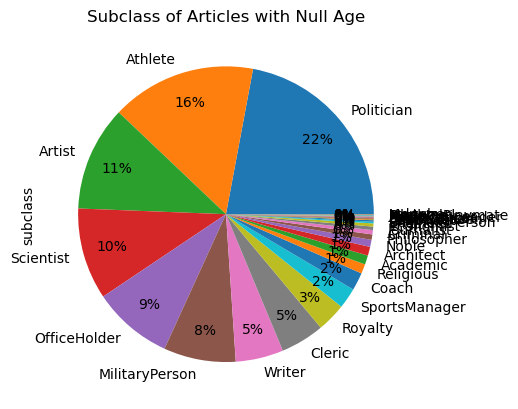

In [95]:
# make a pie chart
subclass_null_age = null_age['subclass'].value_counts(dropna=False)
subclass_null_age.plot.pie(autopct='%1.0f%%', pctdistance=0.8, radius=1, title="Subclass of Articles with Null Age");

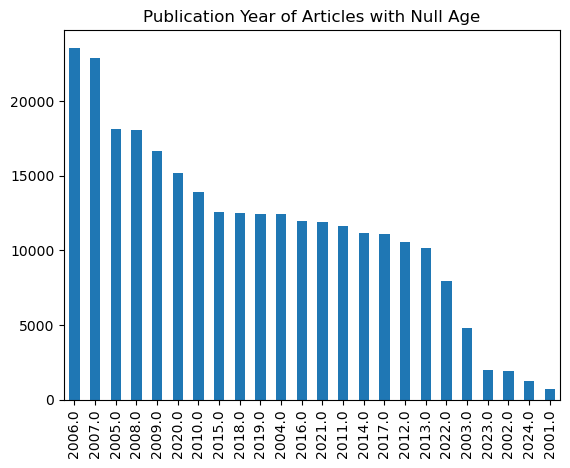

In [96]:
# make a pie chart
publication_null_age = null_age['publication_year'].value_counts()
publication_null_age.plot.bar(title="Publication Year of Articles with Null Age");

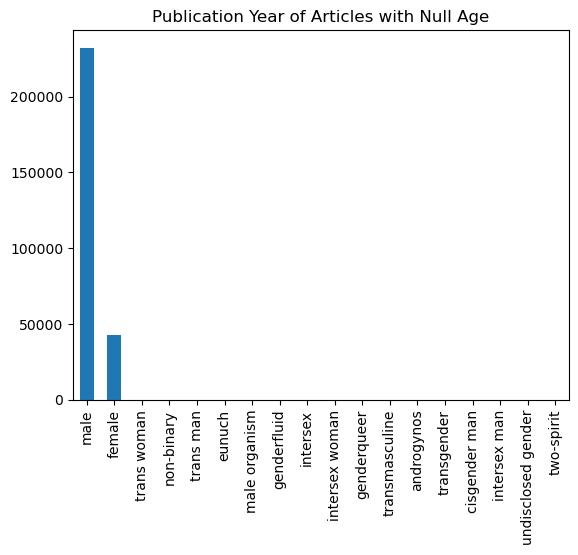

In [97]:
# make a pie chart
gender_null_age = null_age['gender'].value_counts()
gender_null_age.plot.bar(title="Publication Year of Articles with Null Age");

#### Export Data to CSV file

<strong> a) Whole Dataset (for Main Dashboard) </strong>

In [98]:
df9 = df8.drop(columns=['birthYear', 'wikiDataID'])

In [99]:
df9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740524 entries, 417884 to 102472
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   subclass          740524 non-null  object 
 1   instance          740524 non-null  object 
 2   gender            740524 non-null  object 
 3   age               465414 non-null  float64
 4   publication_year  740524 non-null  float64
dtypes: float64(2), object(3)
memory usage: 33.9+ MB


In [100]:
df9.isna().sum()

subclass                 0
instance                 0
gender                   0
age                 275110
publication_year         0
dtype: int64

In [101]:
# df9.to_csv("final_2.0.csv", index=False)

<strong> b) Non-Binary Dataset (for Non-Binary Dashboard) </strong>

In [102]:
non_binary = df9.loc[~df['gender'].isin(['male', 'female'])] 

In [103]:
non_binary.to_csv("non_binary.csv", index=False)

<strong> c) Copy DataFrame for EDA </strong>

In [104]:
df10 = df9.copy()

## 2) Exploratory Data Analysis (EDA)

### 2.1 Univariate EDA

#### 2.1.1 Column subclass

In [105]:
# summarize subclass
df10["subclass"].describe()

count      740524
unique         35
top       Athlete
freq       237949
Name: subclass, dtype: object

In [106]:
# distribution of the 'subclass' column
subclass_distribution = df10["subclass"].value_counts()
subclass_distribution

Athlete            237949
Politician         124494
Artist              88273
OfficeHolder        48601
Scientist           45002
MilitaryPerson      44349
Writer              29610
SportsManager       28515
Cleric              22788
Royalty             19845
Coach               10037
Noble                6609
Criminal             5223
Religious            4595
Architect            4520
Academic             4153
Philosopher          2883
BeautyQueen          2613
Model                1923
Journalist           1693
Economist            1681
Engineer              749
Chef                  726
Astronaut             601
BusinessPerson        514
Youtuber              508
Presenter             504
PoliceOfficer         310
AmericanLeader        237
Pilot                 226
HorseTrainer          217
Spy                   213
PlayboyPlaymate       182
Monarch               126
Judge                  55
Name: subclass, dtype: int64

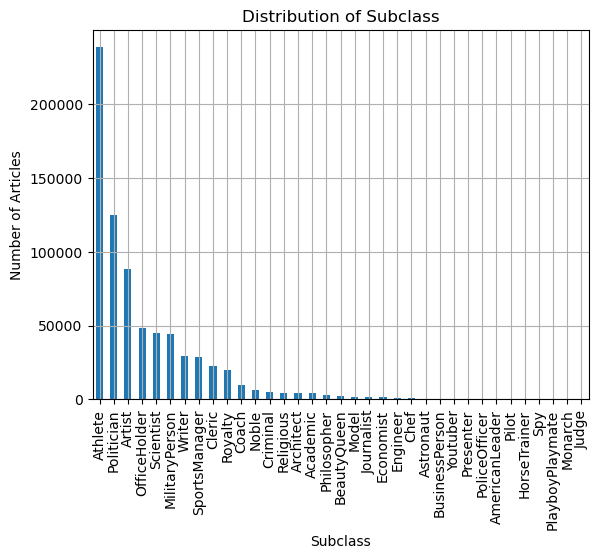

In [107]:
# plot distribution of the 'subclass' column
subclass_distribution.plot.bar(xlabel="Subclass", ylabel="Number of Articles", grid=True, title="Distribution of Subclass");

#### 2.1.2 Column Publication Year

In [108]:
# summarize publication_year
df10["publication_year"].describe()

count    740524.000000
mean       2012.196766
std           5.669489
min        2001.000000
25%        2007.000000
50%        2012.000000
75%        2017.000000
max        2024.000000
Name: publication_year, dtype: float64

In [109]:
# distribution of the 'publication_year' column
publication_distribution = df10["publication_year"].value_counts()
publication_distribution

2006.0    60141
2007.0    58381
2008.0    47894
2009.0    44248
2005.0    43778
2020.0    40637
2016.0    36479
2010.0    36249
2019.0    35827
2015.0    35282
2018.0    34962
2021.0    34134
2011.0    33796
2017.0    32795
2012.0    32576
2014.0    31034
2013.0    28755
2004.0    27521
2022.0    20924
2003.0    10201
2023.0     5614
2002.0     4495
2024.0     3254
2001.0     1547
Name: publication_year, dtype: int64

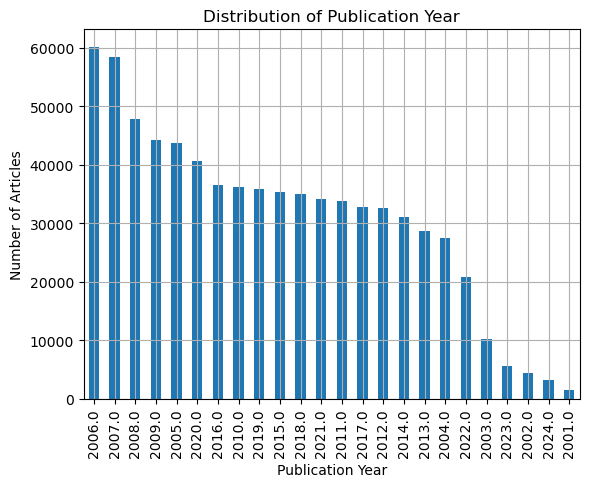

In [110]:
# plot distribution of the 'publication_year' column
publication_distribution.plot.bar(xlabel="Publication Year", ylabel="Number of Articles", grid=True, title="Distribution of Publication Year");

#### 2.1.3 Column Gender 

In [111]:
# summarize gender
df10["gender"].describe()

count     740524
unique        24
top         male
freq      613106
Name: gender, dtype: object

In [112]:
# distribution of the 'gender' column
gender_distribution = df10["gender"].value_counts(dropna=False, normalize=True)
gender_distribution

male                  0.827935
female                0.171296
trans woman           0.000304
non-binary            0.000212
trans man             0.000073
male organism         0.000041
genderfluid           0.000023
eunuch                0.000022
intersex woman        0.000020
intersex man          0.000014
transgender           0.000009
genderqueer           0.000009
intersex              0.000008
two-spirit            0.000007
female organism       0.000005
agender               0.000005
transmasculine        0.000005
cisgender woman       0.000003
androgynos            0.000001
bigender              0.000001
travesti              0.000001
cisgender man         0.000001
faʻafafine            0.000001
undisclosed gender    0.000001
Name: gender, dtype: float64

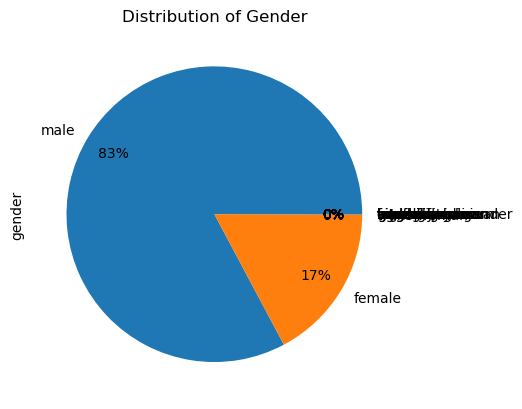

In [113]:
# make a pie chart
gender_distribution.plot.pie(autopct='%1.0f%%', pctdistance=0.8, radius=1, title="Distribution of Gender");

#### 2.1.3 Column Age

In [114]:
# summarize age
df10["age"].describe()

count    465414.000000
mean         49.622012
std          14.759712
min           0.000000
25%          37.000000
50%          51.000000
75%          63.000000
max          72.000000
Name: age, dtype: float64

In [115]:
# distribution of the 'gender' column
age_distribution = df10["age"].value_counts(dropna=True)
age_distribution

72.0    12588
71.0    12524
70.0    12491
69.0    11996
68.0    11964
        ...  
8.0        67
13.0       67
5.0        63
9.0        55
0.0         1
Name: age, Length: 73, dtype: int64

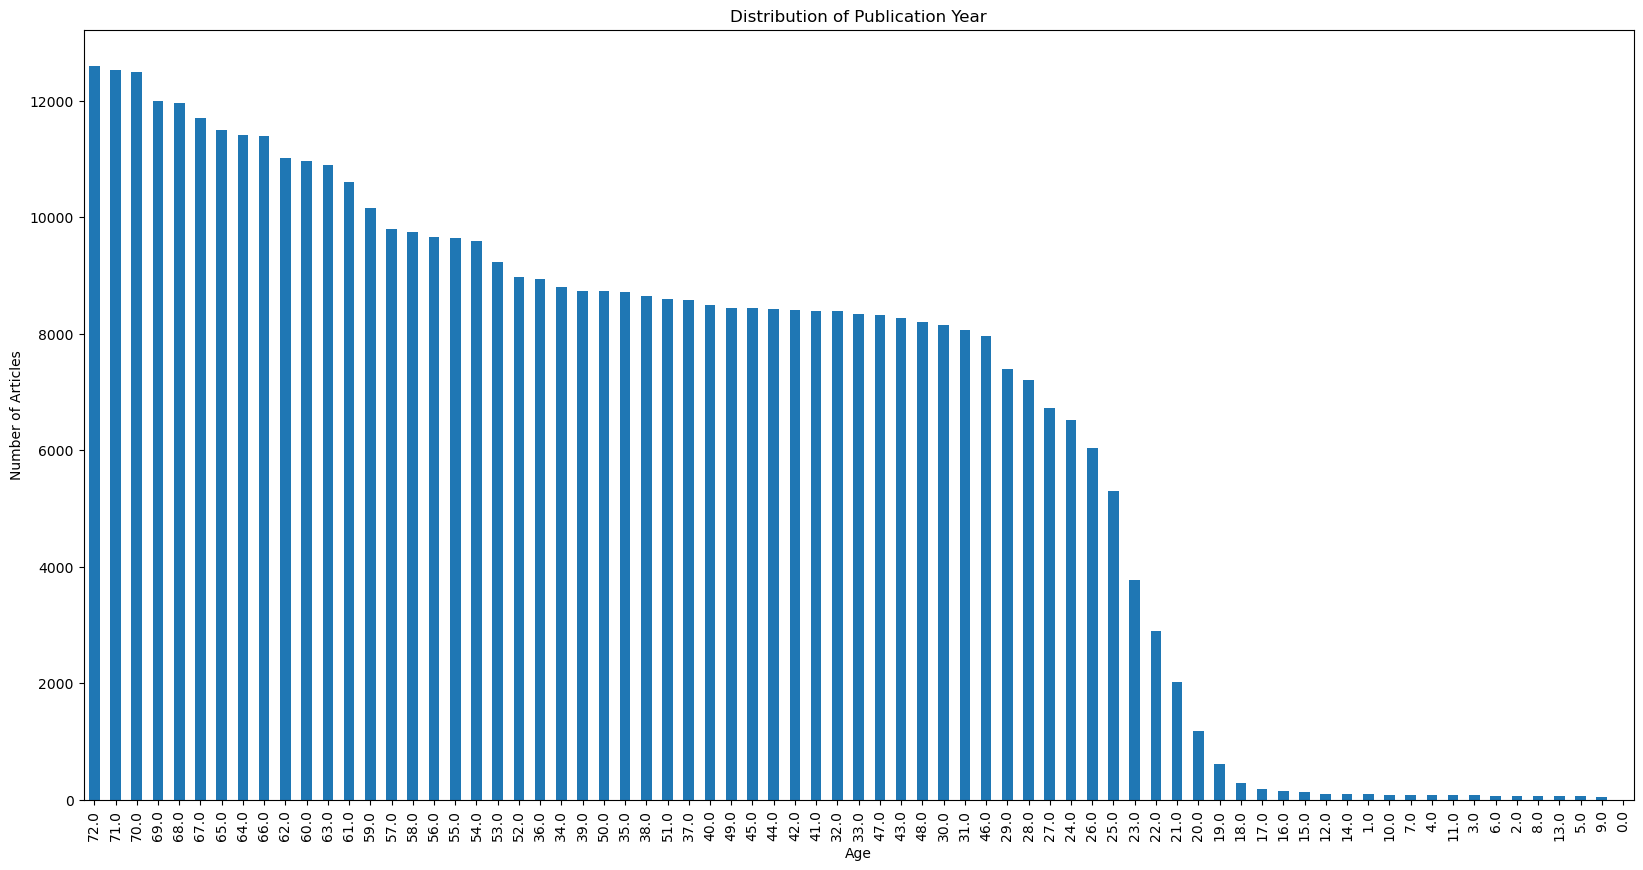

In [116]:
# plot distribution of the 'publication_year' column
age_distribution.plot.bar(xlabel="Age", ylabel="Number of Articles", figsize=(20,10), title="Distribution of Publication Year");

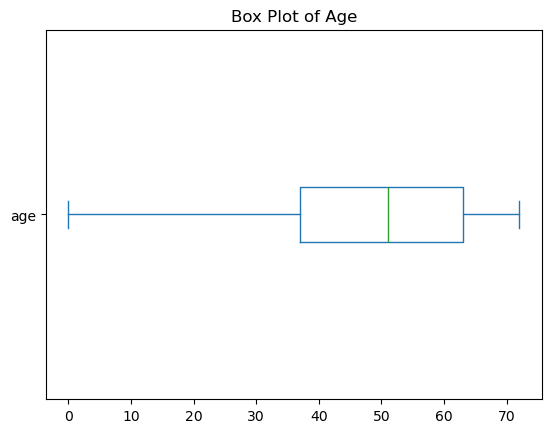

In [117]:
df10["age"].plot.box(vert=False, title="Box Plot of Age");

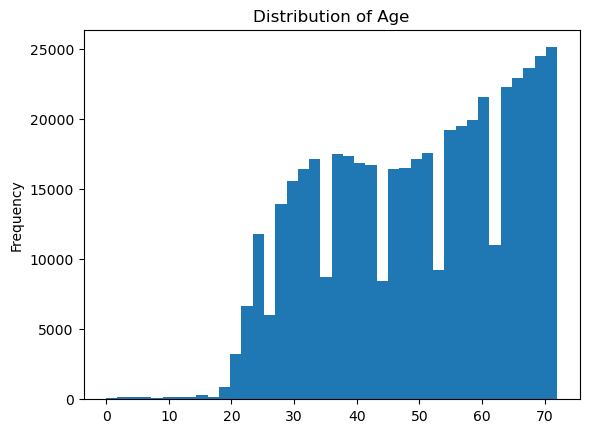

In [118]:
# histogram of Culmen Length (mm)
culmen_length_hist = df10["age"].plot.hist(grid=False, bins=40, title="Distribution of Age");

The histogram's pattern looks like a multimodal, so there might be a multiple factors such as gender, subclass or publication year that might influence the age data.

### 2.2 Bivariate EDA

In [119]:
# !pip install seaborn
import seaborn as sns
from matplotlib import pyplot as plt

#### 2.2.1 Gender and...

<strong>a) Age</strong>

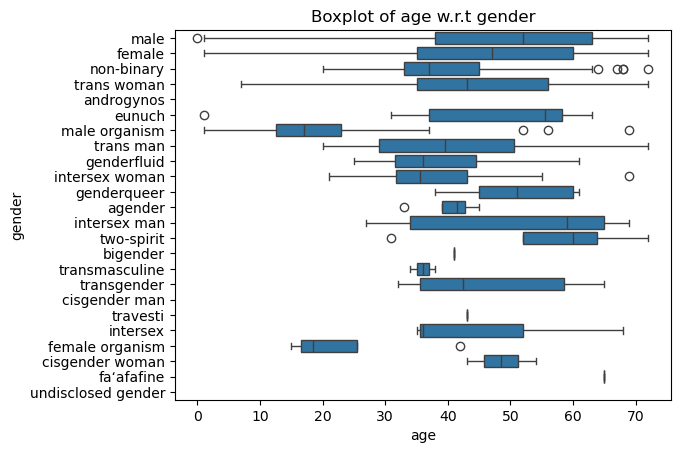

In [120]:
# boxplot of culment length against species
sns.boxplot(data=df10, x="age", y="gender", orient="h")
plt.title("Boxplot of age w.r.t gender");

 <strong>b) Publication Year</strong>

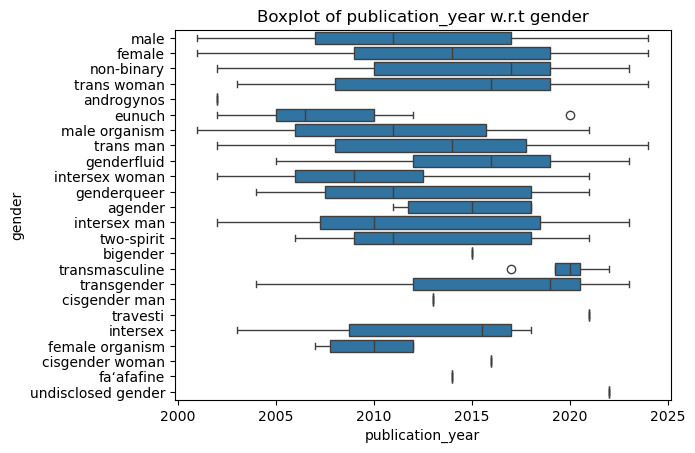

In [121]:
# boxplot of culment length against species
sns.boxplot(data=df10, x="publication_year", y="gender", orient="h")
plt.title("Boxplot of publication_year w.r.t gender");

#### 2.2.2 Subclass and...

<strong>a) Age</strong>

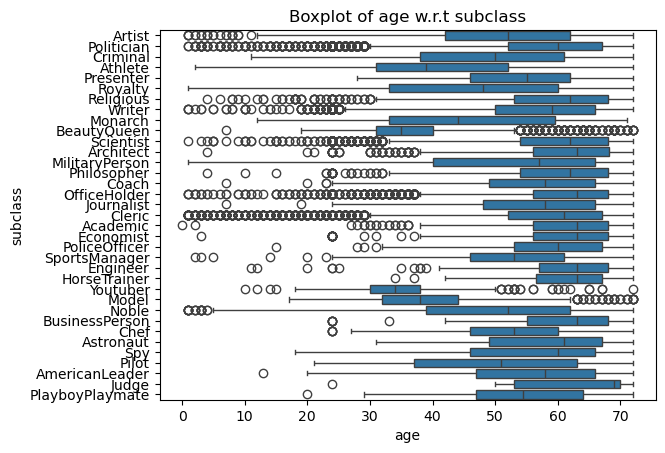

In [122]:
# boxplot of culment length against species
sns.boxplot(data=df10, x="age", y="subclass", orient="h")
plt.title("Boxplot of age w.r.t subclass");

 <strong>b) Publication Year</strong>

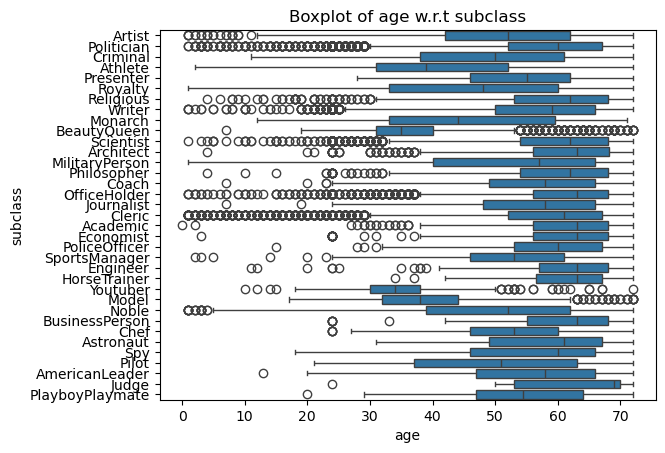

In [123]:
# boxplot of culment length against species
sns.boxplot(data=df10, x="age", y="subclass", orient="h")
plt.title("Boxplot of age w.r.t subclass");

In [124]:
df10.loc[df10['age']==116]

,subclass,instance,gender,age,publication_year


In [125]:
df7.loc[df7['age']==116]

,subclass,instance,gender,age,birthYear,publication_year,wikiDataID
